In [1]:
import numpy as np
import csv
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
# 텍스트 데이터
listFromShortXss = []
listFromLongXss = []
listFromSQL = []

with open('../shortXss.csv','r',newline='') as f:
    reader = csv.reader(f)
    for row in reader:
        listFromShortXss.extend(row)

with open('../longXss.csv','r',newline='') as f:
    reader = csv.reader(f)
    for row in reader:
        listFromLongXss.extend(row)

with open('../SQL.csv','r',newline='') as f:
    reader = csv.reader(f)
    for row in reader:
        listFromSQL.extend(row)

listFromXSS = listFromShortXss + listFromLongXss
texts = listFromSQL + listFromXSS
print(type(listFromSQL), type(listFromXSS))

<class 'list'> <class 'list'>


In [3]:
# 레이블(분류 클래스)
OneforSQL = []
OneforSQL.extend([1 for _ in range(len(listFromSQL))])
OneforSQL.extend([0 for _ in range(len(listFromXSS))])

# print(OneforSQL)

labels = np.array(OneforSQL)

In [4]:
# 토큰화 및 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
max_sequence_length = max(len(seq) for seq in sequences)
data = pad_sequences(sequences, maxlen=max_sequence_length)

In [5]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=0, stratify=labels)
#split = int(0.8 * len(texts))
train_data = X_train
train_labels = y_train
test_data = X_test
test_labels = y_test

In [6]:
# 모델 구성
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_sequence_length))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [7]:
# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
# 모델 훈련
model.fit(train_data, train_labels, epochs=5, batch_size=32)
# epoch = 10

Epoch 1/5
214/214 [==============================] - 191s 882ms/step - loss: 0.1140 - accuracy: 0.9767
Epoch 2/5
214/214 [==============================] - 182s 851ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 3/5
214/214 [==============================] - 180s 839ms/step - loss: 6.8109e-04 - accuracy: 1.0000
Epoch 4/5
214/214 [==============================] - 178s 832ms/step - loss: 3.2803e-04 - accuracy: 1.0000
Epoch 5/5
214/214 [==============================] - 180s 843ms/step - loss: 1.5650e-04 - accuracy: 1.0000


In [9]:
print(np.shape(train_data))
print(np.shape(train_labels))

(6821, 491)
(6821,)


In [10]:
# 모델 평가
loss, accuracy = model.evaluate(test_data, test_labels)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

54/54 [==============================] - 9s 150ms/step - loss: 1.2069e-04 - accuracy: 1.0000
Test Loss: 0.00012068972137058154
Test Accuracy: 1.0


In [11]:
# 모델 예측
X_pred = model.predict(test_data)

54/54 [==============================] - 9s 157ms/step


In [12]:
y_pred = []
for p in X_pred:
    if p <= 0.5:
        y_pred.append(0)
    else:
        y_pred.append(1)

In [13]:
prob = []
for p in X_pred:
    prob.append([1-p, p])

In [14]:
fprs, tprs, thresholds = roc_curve(test_labels, y_pred)

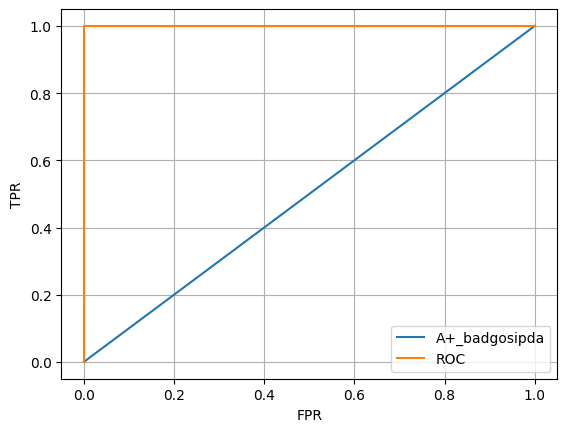

In [15]:
plt.plot([0, 1], [0, 1], label='A+_badgosipda')
plt.plot(fprs, tprs, label='ROC')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()

In [16]:
import scikitplot as skplt

In [ ]:
skplt.metrics.plot_roc_curve(test_labels, prob)
plt.show()

In [18]:
cm = confusion_matrix(test_labels, y_pred)
print(cm)

[[835   0]
 [  0 871]]


In [ ]:

# print(y_test.shape, y_pred.shape)
print(cm.shape)
print("Confusion matrix:\n", cm)

labels = ['SQL', 'XSS']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
#plt.show()
plt.savefig('confusion_matrix.png', dpi=300)

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       835
           1       1.00      1.00      1.00       871

    accuracy                           1.00      1706
   macro avg       1.00      1.00      1.00      1706
weighted avg       1.00      1.00      1.00      1706



In [21]:
from sklearn.metrics import f1_score
print(f1_score(y_test, y_pred))

1.0
